___

#### Group 2:
#### DJ Dawkins, Rick Fontenot, Joe Lazarus, Puri Rudick
___


___
<a id="main"></a>
# Lab 3: Clustering

This Notebook will cover the following topics in order: 
___
<a href="#Prologue">Preliminary raw data prepartion</a> : Data Cleaning and preparation. <br>
<br />

1) <a href="#business"> Business Understanding</a> :Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific


2) <a href= "#du1"> Data Understanding 1</a>: Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

3) <a href = "#du2"> Data Understanding 2</a>: Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

* <a href="#lr"> Data Understanding using linear regression</a>: We make some baseline linear regression models that we will attempt to improve upon using different clustering algorithms.
* <a href="#rf"> Data Understanding using Random Forest</a>: We make a baseline random forest regression model that we will attempt to improve upon using different clustering algorithms.

4) Modeling and Evaluation 1: Train and adjust parameters 

* <a href="#me1d"> DBSCAN Clustering </a> <br />
* <a href="#me1k"> KMeans Clustering </a> <br />
* <a href="#me1s"> Spectral Clustering </a> <br />

5) Modeling and Evaluation 2: Evaluate and compare <br />
* <a href="#me2d"> DBSCAN Clustering </a> <br />
* <a href="#me2k"> KMeans Clustering </a> <br />
* <a href="#me2s"> Spectral Clustering </a> <br />

6) Modeling and Evaluation 3: Visualize Results <br />
* <a href="#me3d"> DBSCAN Clustering </a> <br />
* <a href="#me3k"> KMeans Clustering </a> <br />
* <a href="#me3s"> Spectral Clustering </a> <br />

7) Modeling and Evaluation 4: Summarize the ramifications <br />
* <a href="#me4d"> DBSCAN Clustering </a> <br />
* <a href="#me4k"> KMeans Clustering </a> <br />
* <a href="#me4s"> Spectral Clustering </a> <br />

8) <a href="#deploy"> Deployment</a>: Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling? How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?

9) <a href ="#ex"> Exceptional Work</a>: You have free reign to provide additional analyses or combine analyses

  

In addition to evaluating clustering effectiveness with SSE and Silhouette metrics, we will also evaluate whether location clustering improves regression models to predict airbnb prices.

From previous modeling we know that beyond location, the most important features in predicting price are:
room_type
num_baths (to be extracted from the bathrooms_text in the raw file)
accommodates
availability_30

For Location features we will compare:
1) neighbourhood_group_cleansed
2) listing unique latitude & longitude
3) various clustering methods using latitude & longitude

We will reduce our base dataset to these features and add one-hot encoded clustering for each algorithm to compare price regression performance with MAE and R^2

In [114]:
#list of columns to import
col_list = ["id", "price", "room_type", "bathrooms_text", "accommodates", "availability_30", "latitude", "longitude", "neighbourhood_group_cleansed"]


<a id="Prologue"></a>
___
# Preliminary Data Preparation
___
Cleaning raw data and new feature creation

- Imports
- load data
- Data Quality 
- New Features
- Check missing values
- handling missing values
- check for duplicates

In [115]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import date
import sklearn
pd.set_option("display.max_columns", None, "display.max_rows", None)
import missingno as msno


### Load the raw data

NYC Airbnb data obtained from http://data.insideairbnb.com/united-states/ny/new-york-city/2021-08-04/data/listings.csv.gz

In [116]:
# Load Raw Data
listings=pd.read_csv("https://raw.githubusercontent.com/rickfontenot/airbnb/main/airbnb_nyc_listings.csv?token=ARN5NNHQQO5DGH6T72FBV2DBGD342", usecols=col_list)

listings.head()

,id,neighbourhood_group_cleansed,latitude,longitude,room_type,accommodates,bathrooms_text,price,availability_30
0,2595,Manhattan,40.75356,-73.98559,Entire home/apt,1,1 bath,$150.00,6
1,3831,Brooklyn,40.68494,-73.95765,Entire home/apt,3,1 bath,$75.00,0
2,5121,Brooklyn,40.68535,-73.95512,Private room,2,NaN,$60.00,30
3,5136,Brooklyn,40.66265,-73.99454,Entire home/apt,4,1.5 baths,$275.00,7
4,5178,Manhattan,40.76457,-73.98317,Private room,2,1 bath,$61.00,3


In [117]:
# Examin Data types
listings.dtypes


id                                int64
neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
room_type                        object
accommodates                      int64
bathrooms_text                   object
price                            object
availability_30                   int64
dtype: object

### Regular Expressions
**Price** : our other target variable, is currently an object data type. We need to convert this to a floating point integer. This requires the use of a regular expression to remove "$" and "," from string and convert to float.

In [118]:
print(listings.price.dtypes) #initial type is object
print(listings.price.loc[[299]]) #original value "$2,500.00"
listings.price = listings.price.replace('[\$,]', '', regex=True).astype(float)
print(listings.price.dtypes) #transformed type is float64
print(listings.price.loc[[299]]) #new value is 2500.0

object
299    $2,500.00
Name: price, dtype: object
float64
299    2500.0
Name: price, dtype: float64


**Text Parsing**  bathrooms_text in its current form is not atomized. Meaning it contains more than more piece of information. It contains the Numeric quantity bathrooms and string values describing if it is shared or private. Create dictionary to parse strings and create two new variables of correct type.<br>
<br />

This work goes beyond the scope of data type and into **Data Quality** and **New Features** If we decide to present this for credit, we will present this work again in those sections.<br>
<br/>
Two new columns are being created from *bathroom_text*: **num_baths** and **bath_type**
- **num_baths** will be a floating point value
- **bath_type** will be a categorical value.

In [119]:
#convert nAn values to 'NA' for parsing, will change back to nAn after splitting
listings['bathrooms_text'] = listings['bathrooms_text'].astype(object).replace(np.nan, 'NA')

#Create translation dictionary since description formats are not consistent
transdict = {'1 bath': '1 private', 
             'NA': 'NA',
             '1.5 baths': '1.5 private',
             '1 shared bath': '1 shared', 
             '1 private bath': '1 private',
             'Shared half-bath': '0.5 shared',
             '2 baths': '2 private',
             '1.5 shared baths': '1.5 shared',
             '3 baths': '3 private',
             'Half-bath': '0.5 private',
             '2.5 baths': '2.5 private', 
             '2 shared baths': '2 shared',
             '0 baths' : '0 private',
             '4 baths':'4 private', 
             '0 shared baths': '0 shared',
             'Private half-bath': '0.5 private',  
             '4.5 baths' :'4.5 private', 
             '5.5 baths': '5.5 private' , 
             '2.5 shared baths': '2.5 shared',
             '3.5 baths': '3.5 private', 
             '15.5 baths': '15.5 private', 
             '5 baths': '5 private', 
             '3 shared baths': '3 shared', 
             '4 shared baths': '4 shared',
             '6 baths': '6 private', 
             '3.5 shared baths': '3.5 private', 
             '6 shared baths' : '6 shared',
             '6.5 shared baths': '6.5 shared', 
             '4.5 shared baths' :'4.5 private',
             '5.5 shared baths' : '5.5 private', 
             '7.5 baths': '7.5 private', 
             '5 shared baths': '5 shared',
             '6.5 baths': '6.5 private', 
             '8 baths': '8 private', 
             '7 shared baths':'7 shared', 
             '7 baths': '7 private', 
             '10 baths': '10 private'}

#use trandict to iterate over bathrooms_text column
listings['bathrooms_text'] = [transdict[letter] for letter in listings['bathrooms_text']]

#use str.split to create two new columns 'num_baths' and 'bath_type'
listings[['num_baths','bath_type']] = listings['bathrooms_text'].str.split(' ', 1, expand = True)

#For num_baths convert 'NA' values back to nan and convert type to float
listings['num_baths'] = listings['num_baths'].astype(object).replace( 'NA',np.nan)
listings['num_baths'] = listings['num_baths'].astype(np.float16)

#For bath type convert 'NA' values back to nan and convert type to category
listings.bath_type.fillna(value=np.nan, inplace=True)
listings['bath_type'] = listings['bath_type'].astype('category')
 


### Dropping bathroom_text 
num_baths and bath_type now represent the data that was contained in bathroom_text

In [120]:
#Confirm conversions for bathroom text
print(listings.num_baths.dtypes) #transformed type is float16
print(listings.num_baths.unique())
print(listings.bath_type.dtypes) #transformed type is category
print(listings.bath_type.unique()) 

#Drop original bathrooms_text column now that replaced by two new variables
listings.drop('bathrooms_text', axis=1, inplace=True)

float16
[ 1.   nan  1.5  0.5  2.   3.   2.5  0.   4.   4.5  5.5  3.5 15.5  5.
  6.   6.5  7.5  8.   7.  10. ]
category
['private', NaN, 'shared']
Categories (2, object): ['private', 'shared']


### Check Work
Check current data types for all variables before converting to desired types

In [121]:
print(listings.dtypes)

id                                 int64
neighbourhood_group_cleansed      object
latitude                         float64
longitude                        float64
room_type                         object
accommodates                       int64
price                            float64
availability_30                    int64
num_baths                        float16
bath_type                       category
dtype: object


### Data Type Dictionary
In this step we are coercing the pandas to recognize the columns in the data type that best represents each particular type of observation.<br>
<br />
To do so Data Type dictionary is created and convert all variables to proper format and bit sizes based on the key value pair.

In [122]:
convert_dict = {
'neighbourhood_group_cleansed': 'category',
'room_type': 'category',
'accommodates': 'Int16',
'price': 'float64',
'availability_30': 'Int16',
'num_baths': 'float64',
'bath_type': 'category'
               }
  
listings = listings.astype(convert_dict, errors='ignore')
print(listings.dtypes)

id                                 int64
neighbourhood_group_cleansed    category
latitude                         float64
longitude                        float64
room_type                       category
accommodates                       Int16
price                            float64
availability_30                    Int16
num_baths                        float64
bath_type                       category
dtype: object


### Check missing values
This check is done to ensure we've preserved the data integrity and its missing values.

In [123]:
listings.isna().sum()

id                                0
neighbourhood_group_cleansed      0
latitude                          0
longitude                         0
room_type                         0
accommodates                      0
price                             0
availability_30                   0
num_baths                       109
bath_type                       109
dtype: int64

## Preserving variables with missing values

For variables with  less than 1,000 missing values (less than 2.7% of observations), we chose not to impute. It may be the case that the lack of data is data in and of itself. Guests may be influenced by the lack of data when choosing a listing. During our analyses we will consider this. In certain cases we may filter. <br><br /> Those variables are:
* num_baths (new variable)
* bath_type (new variable)

In [124]:
print("Dataframe Size before dropping NA: ",listings.shape)
listings.dropna(inplace= True)
print("Dataframe Size after dropping NA: ",listings.shape)

print(listings.isna().sum())


Dataframe Size before dropping NA:  (36724, 10)
Dataframe Size after dropping NA:  (36615, 10)
id                              0
neighbourhood_group_cleansed    0
latitude                        0
longitude                       0
room_type                       0
accommodates                    0
price                           0
availability_30                 0
num_baths                       0
bath_type                       0
dtype: int64


## Check for Duplicate Data

In [125]:
# Check for duplicate rows
print('Duplicate rows: ',listings.duplicated(keep='first').sum())


Duplicate rows:  0


# Section 1: Business Understanding <a id="business"></a>

<p><b>Who</b>:      Airbnb is an online market place that connects people. It acts as an intermediary between those who wish to rent out their homes with people looking for accommodations in that locale. In that way Airbnb does not does not own any properties. Airbnb makes money by charging a service fee. The service fee is a percentage of the total bill to both guests and hosts. Hosts are responsible for the management of the property. They must buy or rent the property, coordinate with guests, and clean up after them. </p>



<p><b>Where</b>:        The data comes from <a>http://data.insideairbnb.com/united-states/ny/new-york-city/2021-08-04/data/listings.csv.gz</a>. This website was funded by Murray Cox. The site is not associated with or endorsed by Airbnb or their competitors. The data utilizes public information compiled from the Airbnb website. Listings on Airbnb can be deleted from the platoform. The data presented by Inside Airbnb represents a snapshot at a particular time, August 4, 2021 </b> Our particular focus is on NYC, New York.</p>

<p><b>What</b>:         We want to use this data to predict the following:<br>
<br />
    <ol> 
        1. <b>Superhost</b> <br>
        <br />
        - With the data we will predict Superhost status. This is a classification problem. <br>
        <br />
        - In order to measure the effectiveness of our model we will accuracy as our metric.<br>
        <br />
        2. <b>Price</b> <br>
        <br />
            - With the same data set will predict price of a listing. This is a regression problem. <br>
        <br />
            - In order to measure the effectiveness of our model we will use Root Mean Squared error (RMSE).
</ol>
</p>

<p><b>Why:</b>       Why is our analysis important. The superhost badge is a big deal to people who host on Airbnb. It means greater visibilty and increase in trust with prospective guests. This adds up to loss of potential earnings if denied access. Is Airbnb consistent with their superhost rating? Airbnb publish guidlines for becoming a superhost. Are they consistent when it comes to applying these rules or is the some bias towards certain types of hosts?<br> Hosts set their own price. There is an incentive to maximize price. But what factors are most important? Setting the correct price to the market allows hosts to reach the full capitalization potential of their listing. </p>

<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>


___
# Section 2: Data Understanding 1 <a id="du1"></a>

<p>
    
Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

#### [10 points total]
___    
    
* **id** – The ID column is the unique four-digit number given to a particular listing. To be more explicit this column is listing ID. The column serves as a primary key for a particular property. Values are int64.<br>
<br />
* **name** - The name column is the name apellation given to the listing by the host. The host creates a moniker for each listing they put on Aibnb. It can describe the property and entice would be guests to stay there. It is an object data type that contains a string value.<br>
<br />
    
* **last_scraped** - Datetime64[ns] data type. Describing the date the listing was last scraped using inisdearibnb.com web api.<br>
<br />
* **description** - Hosts on Airbnb are invited to give their listing a description. This serves to help guests gain understanding about the listing. According to [Airbnb](https://www.airbnb.com/resources/hosting-homes/a/sprucing-up-your-listing-description-13), "A great listing description is one of your best tools for securing bookings and setting guests’ expectations. We’ve learned from Superhosts that your property doesn’t have to be perfect, but it’s crucial to tell guests exactly what they’ll find when they arrive..." It is an object data type contain a string of characters. <br>
<br />
* **host_ID** – Host ID is four-digit number that servers as a primary key for a host. Hosts are those who have rights to a certain property through ownership, leases or granted managerial authority. There is no limit to the number of properties they can list on Airbnb. Guests and Hosts have the abilitly to read one another’s profiles. Guests might be influenced by a Hosts reviews or status as a super host. Data type of int64. <br>
<br />
* **host_Name** – Is typically the first name of the host. This column data type of object made up of character strings. Host are property owners/managers of a given property. Guests and Hosts first names are available to users on Airbnb. Sharing this piece of information allows users personally address one another as they coordinate stays. By withholding last names, a bit of user privacy is preserved.<br>
<br />
* **host_Since** – This column reflects the date at which a host listed their first property with Airbnb. The data set uses military format, a numerical representation of year month day delineated by a hyphen. Example 2012-01-09. Data type datetime64[ns].  <br>
<br />
* **host_location** - Object data type made up of character strings that details where the host is located. Given in the format City, State, Country. Hosts may or may not be co-located in the same city. There is no limit to the number of properites a host can list. Only that they provide to Airbnb proof of rights to a particular property in order to list it on the website. <br>
<br />
* **host_about** - Object data type made up of character strings that provides background information regarding the host. Written by the host to prospective guests. This about allows guests to get a sense of who they are renting the property from. <br>
<br />    
* **host_response_time** -  This column's data type is category that approximates how long it takes for a host to reply to an inquiry. The strings have a ordinal relationship. The fastest to slowest response are denoated as: “within an hour”, “within a few hours”, “within a day”, “a few days or more”. This information is available on the website to prospective guests. <br>
<br />
* **host_response_rate** – This column is a percentage of how often a host replies to an inquiry sent to them on the Airbnb website. The data type is int16. The values are continuous from  0 through 100. This information is available on the Airbnb website to prospective guests. <br>
<br />
* **host_acceptance_rate** –  Conintous values from 0-100 and data type int16. This column is a percentage of how often a host will accept a guests request to stay vs reject this request. from  On Airbnb guests have the ability to choose their accommodations. Likewise, Hosts can accept or reject a guests request to stay. This could be a factor of scheduling and timing. Or a factor of a guests poor rating. Hosts and guests rate one another after a stay. The cumulative rating servers as a social credit on the website. This can influence a hosts decision to accept a guests request to stay at their place. <br>
<br />
* **host_neighborhood** -  Category data type denoted the which neighborhood in New York city the listing comes from. The total number of possible neighborhoods are 450. The list contains neighborhoods outside of New York. It maybe it is referencing another neighborhood where the host owns and lists properties. <br>
<br />
* **host_listings_count** – Numeric value of the number of properties a host has listed on Airbnb. The count is not limited to the New York City geographical area that we are focusing on for this project. Data type of int16. Values range from blank, 0 – 3966. <br>
<br />
* **host_verifications** – The coloumn is a list of strings values denoting the method in which as host as verified their identity. Typical methods include government ID, email, phone, and reviews. This process ensures safety and that the host is at least 25 years old.  <br>
<br />

* **neighbourhood** - Object data type of category denoted the which neighborhood in New York city the neighborhood the listing is located in. This value also includes the city, and country. List contains 209 unique values. <br>
<br />
* **neighborhood_overview** - Object data type string describing the neighborhood where the listing in located within NYC, NY. <br>
<br />    
* **neighbourhood_cleansed** – Object data tyoe of category indicating the neighborhood where the listing is located. Contains 223 unique values. <br>
<br />
* **latitude** – Is measurement on a globe or map of location north or south of the equator. Geocentric latitude, which is the most common and one used here, is the arc subtended by an angle at Earth’s centre and measured in a north-south plane poleward from the Equator. Stated as floating point number (float64). Read as Degrees, minutes, seconds and decimal seconds (DMS). A far more gentlemanly way of referncing geocentric location is MGRS and is the preferred method amongst the more refined cartographic users.<br>
<br />
* **longitude** – Is a measurement of location east or west of the prime meridian at Greenwich, the specially designated imaginary north-south line that passes through both geographic poles and Greenwich, London. Also measured in degrees, minutes, seconds, and decimal seconds, longitude is the amount of arc created by drawing first a line from Earth’s centre to the intersection of the Equator and the prime meridian and then another line from Earth’s centre to any point elsewhere on the Equator. Stated as floating point number (float64).<br>
<br />
* **property_type** – Category describing the type of rental the host is offering. For example, entire rental unit, entire guest house, shared room in guest house, entire villa, shared room in loft. Contains 75 unique values. <br> 
 <br />   
* **Room_type** – Category that is a more general description of the listed property type. Contains 4 unique values. Entire home/apt, private room, hotel room, shared room.   <br>
<br />    
* **Accommodates** – Int16 data type of numeric values describing how many people the listed property can accommodate at one time. List is between 0 – 15. <br>
<br />

* **Bedrooms** – Int16 data type indicating the number of bedrooms the listing contains. The values range from 1 – 14. 
<br />    
* **Beds** – Int16 data type indicating how many beds the listed property has. A bedroom may contain more than bed. Contains 22 unique values from nan \& 1-42.   <br>  
<br />
* **amenities** – Object data type contains list of string values indicating desirable features the host provides as part of the listing.  According the Airbnb website “essentials” indicates toilet paper, soap (for hands and body), one towel per guest, one pillow per guest, linens for each guest bed. There are 30485 unique values in this column.<br>
<br />    
* **price** -  Float16 value indicating the cost per night to stay at the listing. Values range from 0 – 10,000 in U.S. Dollars. There are 853 unique values in this column.<br>
<br />
* **minimum_nights** -  This value is a Int16. This column indicates the number minimum number of nights a guest must reserve the listing for. Values range from 1 – 1250. With 128 unique values. <br>
<br />    
* **maximum_nights** -  Int64 data type ranging from 1 – 2147483647.  This is the maximum number of nights a guest my reserve the property for. <br>
<br />

* **availability_30** – The number of nights the listing is available within the next 30 days. The availability could be a factor of bookings. Can also be a factor of the host living in the property, since some properties listed on Airbnb are hosts primary residence.Int16 Values range from 0-30. 50% of the observations have 0 availability. The mean is 7.03 std of 10.5.   <br>  
<br />
* **availability_60** – Similar meaning to the previous column except that it extends the time horizon out to 60 days. Float values but for intents and purposes are an integer value. 50% of the properties have 2 or fewer nights available. Mean is 16.7 with std of 21.8. Int16 values range from 0-60.<br>
<br />
* **availability_90** – This column extends the availability time horizon out to 90 days. 50% of the listing have 5 nights or fewer. Mean is 28.2 std of 34.03. Int16 values range from 0 - 90. <br>
<br />
* **availability_365** – This column extends the availability time horizon of a listing out to 365 days. 50% of the listings have 57 nights or fewer. Mean is 122.5 std of 138. Int16 Values range from 0-365.<br>
<br />
* **number_of_reviews** -  Int16 values. This represents the total number of reviews a property has. After a stay a guest may write a review of the property at which they stay at. They may comment on the property and the host. Values range from 0 – 998. 50% of the properties have 4 or fewer reviews. Mean is 22.8 std is 49.18.<br>
<br />
* **number_of_reviews_ltm** – Similary to the previous column but the lookback window is _last twelve months (LTM)_.  Max value is 669. 75% of the observations have 0 or fewer reviews. Int16 value. Values range from 0-669. <br>
<br />
* **number_of_reviews_l30d** – Similar to the previous column except the lookback window is limited to past (last) 130 days. 75% of the observations have 0 reviews. Max value is 172. 25 observations. 6560 observations do contain reviews. Int16 data type.
<br />    
* **first_review** – Datetime64[ns] data type. Date at which a listed property was first reviewed. The data set uses military format, a numerical representation of year month day delineated by a hyphen. Example 2012-01-09. There are 9,415 observations without a first review.<br>
<br />
* **last_review** – Datetime64[ns] data type. Date at which a listed property received its most recent (aka last) review. The data set uses military format, a numerical representation of year month day delineated by a hyphen. Example 2012-01-09. There are 9,415 observations without a last review. <br>
<br />
* **review_scores_rating** -  Guests who have stayed at a listing may rate the listing on a scale from 0-5. The mean is 4.5. Values range from 0-5. There are 158 unique ratings. 9415 observations do not have a rating. Scaled values using the star rating system from 0-5  float16 data type. <br>
<br />
    
*The following (6) columns are detailed ratings. Ratings use a commonly understood star review system, scaled from 0-5 and given as a floating point number.  Guests who've stayed at the listing are invited to rate the hosts listings with respect to certain aspects of the stay. 1) Accuracy, 2) cleanliness, 3) communication, 4) location, 5) check in, 6) value. The score related to each of the 6 categories becomes part of the hosts and listings cumulative rating. Guests available to view this rating on the Airbnb website.* <br>
<br />

* **review_scores_accuracy** –  Float16 data type. Scaled from 0-5 guests are asked to rate how accurately the host described the property on the Airbnb website. 26,661 listings have a score. The mean is 4.7 std 0.48. 158 unique ratings exists within this data frame and 10,063 observations do not have an accuracy score. <br>
<br />
* **review_scores_checkin** – Float16 data type. Scaled from 0-5 guests are asked to rate how easy the check-in process was. 26,672 have a rating. Mean is 4.61, std 0.57 values range from 0-5, with 199 unique ratings. 10,071 do not have a check in rating. <br>
<br />
* **review_scores_communication** – Float16 data type. Scaled 0-5 guests are asked to rate how promptly a host responds to guests messages on the Airbnb website. 26,664 observations have a rating. The mean is 4.8 std 0.45 values range from 0-5. 10,060 observations do not have a communication rating. <br>
<br />
* **review_scores_location** – Float16 data type. Scaled 0-5 guests are asked to rate the listing based on “Was the guest made aware of safety, transportation, points of interest and special considerations like noise or other situations that might affect their stay?” [Refernce: Airbnb help ratings](Aibnb.com/help/ratings). 26,664 observations have a rating. The mean is 4.8 std is 0.45 ranging from 0-5. 10,075 do not have a location rating. <br>
<br />
* **review_scores_value** – Float16 data type. Scaled 0-5 guests are asked to rate the listing based on “Was it worth the price?” [Refernce: Airbnb help ratings](Aibnb.com/help/ratings) 26,649 listings have a value rating. The mean is 4.65 std 0.5. values range from 0-5. 158 unique ratings within the column and 10,075 do not have a value rating. <br>
<br />

    _End of detailed review columns._ <br>
<br />

* **calculated_host_listings_count_entire_homes** – Int16 value describing the number of entire homes a host has available on Airbnb website or just NYC? Entire home meaning the guest will the entire domicile to themselves. An entire place usually includes bedroom, a bathroom, and a kitchen. Hosts should make note if they will be on the property for example, host occupies first floor of home. – [Refernce: Airbnb select your home type](Airbnb.com/help/article/317/select-your-home-type) Vales range from 0-286. 75% of the observations have 1 of fewer. Mean is 6.5 std 29.9 and no missing values. <br>
<br />
* **calculated_host_listings_count_private_rooms** – Int16 value describing the number of private rooms a host has available on Airbnb. With private rooms guests will have the their own room for sleepin. Other areas such as kitche or living room, could be shared. Whether or not guests will have their own bathroom should listed in the description.[Refernce: Airbnb select your home type](Airbnb.com/help/article/317/select-your-home-type) values range from 0-276. Mean is 6.7 std 31.16. 75% of the observations have 1 or fewer.<br>
<br />
* **reviews_per_month** – Int16 value denoting how many reviews as listing has received per month / or hosts received per month?. ?how is this calculated? A ratio of the number of reviews divided by the total number of months this listing has been on Airbnb website. Vales range from 0.01 – 192.93. Mean is 1.3 std of 3.85. 9,415 observations are null.  <br>
<br />
* **host_is_superhost** -  Boolean value True / False stating whether host meets condition of currently having the the status of “Superhost”. From Airbnb website “Every 3 months, each host is evaluated on their hospitality. Superhosts meet all of the criteria – they’re highly rated, experienced, reliable, and responsive.” They must meet certain criteria of; 4.8+ rating, 10+ stays, 1% cancellation rate, and 90% response rate.  The number one benefit of being a Superhost is that it improves the visibility of your listings. For one, there is a super host only filter. Superhost properties are more likely to be featured in Airbnb newsletters and curated lists on the Airbnb website. Becoming a super host and sporting the superhost badge builds trust and allows guests to stand out from the crowd. Having the superhost badge my allow hosts to increase their rates. From the host tools website, “Guests expect a higher level of service and a better experience from Superhosts, so it’s likely that they’re willing to pay more.” [From Airbnb website: How to become a SuperHost](https://www.airbnb.com/help/article/829/how-do-i-become-a-superhost).<br>
<br />
* **host_identity_verified** – Boolean value True False of whether or not the host has verified their identity. This value confirms the methods used in host_verifications passed Airbnb’s verification process. <br>
<br />
* **host_has_profile_pic** – Boolean value True / False denoting whether or not the host as uploaded a profile picture. The profile does not necessiarly mean it is of the hosts face. <br>
 <br />   
* **has_availability** – Bool value True / False indicating whether a listing is available at some time. 2096 observations are listed as (False), and 34,628 are (True). <br>    
<br />
* **instant_bookable** – Bool value True / False indicating whether or not a listing has the feature of “instant book” instant book allows prospective guests on the Airbnb website to immediately book without needing to send a request to the Host for approval. Feature is provided at no additional costs. Drawback to hosts is they lose some measure of control over who is booking their listing. 26,967 are not instant bookable and 9,757 are instant bookable. No missing values in this column.  <br>
<br />
* **num_baths** - Float16 value describing the number of baths a listing has. Half bath is represented by point five decimal. Indicating the bathroom does not contain a shower facility. E.G. 1.5 indicated 1 full bath that includes a toilet and shower with an additional facility that only contains a toilet. This column was created by parcing bathroom text. There are (20 ) unique values range from nan, 0 - 15.5 <br>
<br />
* **bath_type** - Category feature describing if the bathrooms at the listing are "shared", "private" or nan (information is not listed). Shared indicates that other guests or hosts may have access to the facility during the guests stay. Private means the guests will have the bathroom facility to themselves. <br>    
</p>

<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>


___
# Data Understanding 2 <a id="du2"></a>


Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

#### [10 points total]
___

### Price, Neighborhood, and Room Type
As they say in real estate “Location, location, location.” and is applicable to Airbnb.  Location (or in this case, neighborhood) can be one of the major variables that drive the price.  Room type also plays a major role in price.

The strip plot below shows listing price in each neighborhood by room type. We can see that the majority of the listing are in Manhattan, Brooklyn, and Queens, respectively.  These same neighborhoods are also the only ones with listings of 10,000 USD.  Manhattan has the highest average listings across all different room types.  

The majority of room types are entire home/apartment and private rooms.  Outside of Manhattan, there aren't many hotel rooms listed.  Staten Island has no hotel rooms listed on Airbnb.  One interesting outlier to note; 
(3) shared room properties listed over 2,000 USD, 2 in Manhattan and another in Queens.  One of those in Manhattan is listed at 10,000 USD!  How can SHARED rooms be so expensive?

When a host lists a shared room as 10,000 USD the host is most likely setting price so high that no one will rent it. By doing so they take it off the market without having to delete listing data from the Airbnb website. 

In [ ]:
# Price, Neighborhood, and Room Type Strip Plot
sns.stripplot(x="neighbourhood_group_cleansed", y="price", hue="room_type", data=listings, dodge=True)
sns.set(rc = {'figure.figsize':(15,10)})

The bar chart below displays the number of each room type listed.  The plot indicates the majority of room types are entire homes/apartments (almost 20,000 listings) and private rooms (more than 16,000 listings).  The number of listings for shared and hotel rooms is comparatively less, supported by the strip plot above.  

In [ ]:
# Room Type Frequency Bar Chart
roomT = listings.room_type.groupby(listings.room_type).agg(['count'])

roomT.plot(kind='bar', title ="Room Type", figsize=(8, 5), legend=False, fontsize=12)
plt.ylabel('Count', fontsize=12)


### Correlation Matrix: Continous Variables

In [ ]:
# Get correlation
corr = listings_continous_columns.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Key Observations:

Gaining more granularity on the correlation matrix the scatter plot shows a linear relationship between beds and accommodates. 

### Key observations:
**Review scores**:
- review_score_accuracy
- review_score_cleaniness
- review_score_checkin
- review_score_communication
- review_score_location
- review_score_value
Are all correlated with each other. 

We interpret this as a host who excels in one category also excels in another. And that a defeciet in one category leads to lower marks in all others. Guests are more likely to grade harshly if they find the host lacking in any one category. 

This is important for a host trying to achieve superhost status. 

**number_of_reviews** & **reviews_per_month**
This is intuitive. Properties with large number of reviews are likely to reviewed more times in a given month. 

**host_listings_count**, **calculated_host_listings_count** & **host_total_listings_count**
These categories display another intuitive correlation. The data set does not come with a definition of terms. And we are unable to derive the meaning between the small variation between the categories.


**accomodates**, **bedrooms** & **beds**
Intuitive the capactity that a listing can accommadte depends on the number of bedrooms and beds. 

Our interpretation is that this can be a host deliberate decision to increase the accomnmodation capacity of their listing. The size and number of bedrooms a listing has is relatively fixed. The host can decide to increase this by bringing in more beds for their guests. This may be done to make the listing more attractive and possibly garner a higher price. More analysis is needed to validate that hypothesis.

### Accomodates vs Beds - Scatter Plot

In [ ]:
plt.figure()
sns.regplot(x=listings.accommodates.astype(float), y=listings.beds.astype(float), scatter_kws={'s':2},
           x_jitter=.1, y_jitter=.1)
plt.ylim(0, 15)

### Latitude and Longitude
Latitude and longitude were used to help us visualize the listings' geographical distribution.

This heatmap below offers a visual representation of listing density by location. The hotter color (reds), the higher the density. Not surprisingly, Manhattan hast the highest density, followed by Brooklyn. Within the Manhattan area, the south of Central Park appears to have the most listings. This could be due to proximity to NYC tourist attractions, e.g. Time Square, Empire State Building, Grand Central Terminal, East Village, Wall Street, etc.

**Note**: the map is interactive. Feel free to scroll in for higher resolution. The map will automatically scale as you zoom in and out. Pretty neat!


In [ ]:
import folium
from folium import plugins

m = folium.Map([40.7128,-74.0060], zoom_start=10)

# convert to (n, 2) nd-array format for heatmap
stationArr = listings[['latitude', 'longitude']].values

# plot heatmap
m.add_child(plugins.HeatMap(stationArr, radius=14))
m

Plotting the geospational data with lat long we can see concentrations of listings. This gave us the idea to us clustering algrothims to mine this type of geospatial data. Are there clusters of listings within the heatmap that can provide a deeper or new understanding of Airbnb listings? We will further explore this topic in the notebook. 

### Neighbourhood Group

Another strong relationship to price is the neighborhood in which the listing is located. Manhattan commands the highest overall prices. This plot also highlights that there is a large range within each neighborhood group too. Exploring breakdowns within them could be helpful for future work. 

We could look at pricing clusters within these neighborhood groups or attempt to add additional data and features for proximity to transportation and popular attractions.

In [ ]:
plt.figure()
sns.boxplot(x='neighbourhood_group_cleansed', y='price', data=listings[listings.neighbourhood_group_cleansed.notna()])
plt.ylim(0, 400)

The boxplot above breaks out the price distrubution among the 5 boroughs in NYC. Our focus with clustering is to see if there are interesting clusters of listings that can ehance our understanding beyond the boundaries of these neighborhoods. 


<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>


<a id="lr"></a>
___
# Data Understanding Linear Regression

Running Linear Regression model. Later we ill include outputs from our clustering analysis in attempt to improve model performance.
___


One-hot encode categorical variables then drop originals.

In [126]:
Categoricals_to_convert = ['neighbourhood_group_cleansed','room_type','bath_type']

# using pd get dummies for the category columns we are keeping
dummies = pd.get_dummies(listings[Categoricals_to_convert],drop_first=True)

#dropping original columns
listings_df = listings.drop(Categoricals_to_convert,axis=1)

#concating dummies to the data frame
listings_df = pd.concat([listings_df,dummies],axis=1)

listings_df.head()

,id,latitude,longitude,accommodates,price,availability_30,num_baths,neighbourhood_group_cleansed_Brooklyn,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,neighbourhood_group_cleansed_Staten Island,room_type_Hotel room,room_type_Private room,room_type_Shared room,bath_type_shared
0,2595,40.75356,-73.98559,1,150.0,6,1.0,0,1,0,0,0,0,0,0
1,3831,40.68494,-73.95765,3,75.0,0,1.0,1,0,0,0,0,0,0,0
3,5136,40.66265,-73.99454,4,275.0,7,1.5,1,0,0,0,0,0,0,0
4,5178,40.76457,-73.98317,2,61.0,3,1.0,0,1,0,0,0,1,0,0
5,5203,40.80380,-73.96751,1,75.0,0,1.0,0,1,0,0,0,1,0,1


<AxesSubplot:>

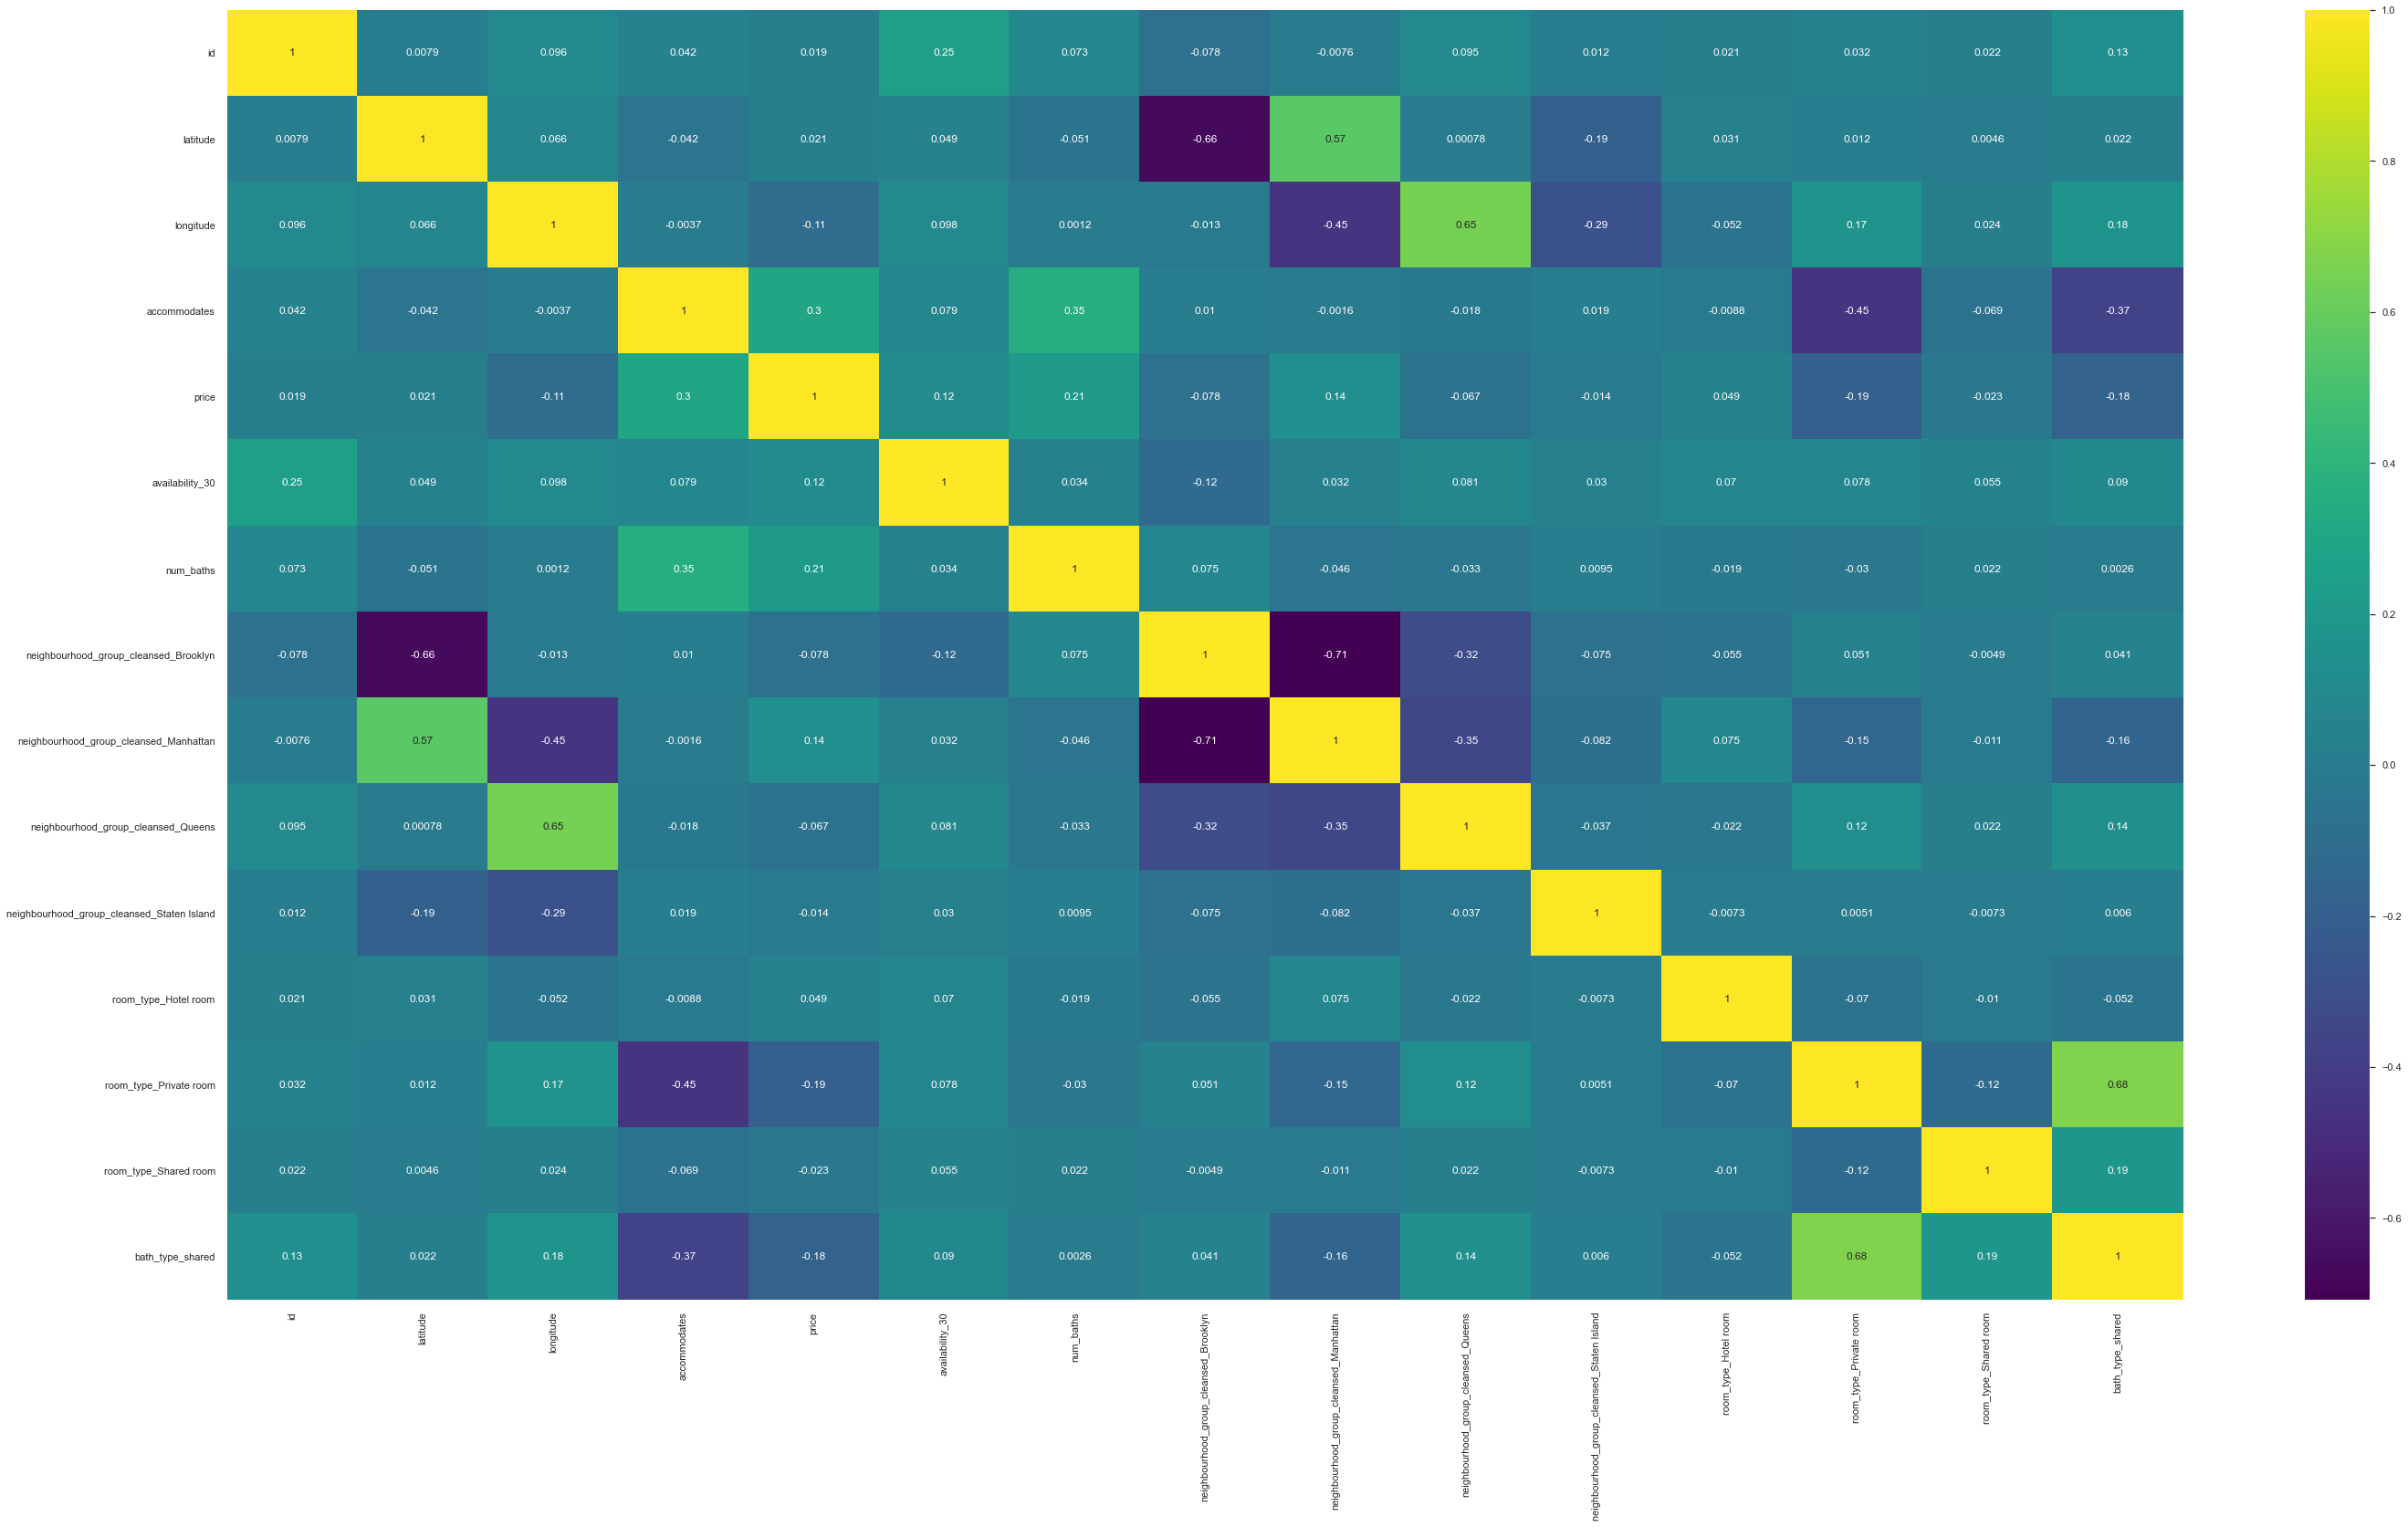

In [127]:
plt.figure(figsize=(48,26))
sns.set(font_scale=1)
sns.heatmap(listings_df.corr(),annot=True,cmap='viridis')

## A closer look on response variable, **Price**

From the histogram and QQ-plot, the variable show heavily righ-skewed distribution.

Skewness: 19.861454
Kurtosis: 574.877327


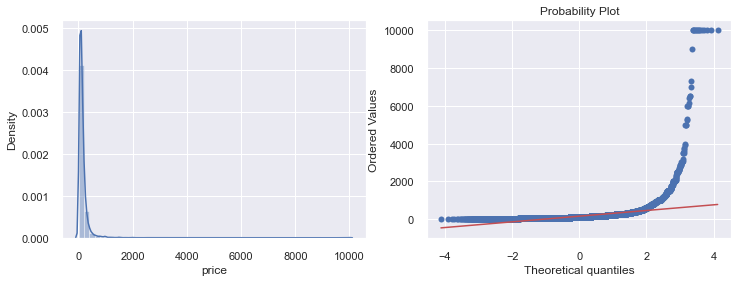

In [128]:
import matplotlib
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")

fig, ax = plt.subplots(1,2, figsize=(12,4))

sns.distplot(listings_df['price'], ax=ax[0])
stats.probplot(listings_df['price'], dist="norm", plot=ax[1])

print("Skewness: %f" % listings_df['price'].skew())
print("Kurtosis: %f" % listings_df['price'].kurt())

Log transformation might help making the response variable more normally distributed.

Skewness: 0.703872
Kurtosis: 1.459337


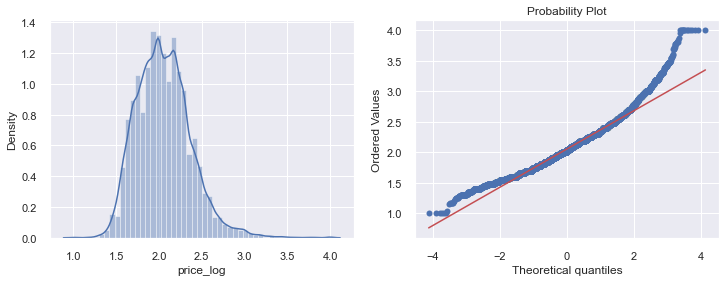

In [129]:
listings_df['price_log'] = np.log10(listings_df['price'])

fig, ax = plt.subplots(1,2, figsize=(12,4))

sns.distplot(listings_df['price_log'], ax=ax[0])
stats.probplot(listings_df['price_log'], dist="norm", plot=ax[1])

print("Skewness: %f" % listings_df['price_log'].skew())
print("Kurtosis: %f" % listings_df['price_log'].kurt())

### **Remove Outliers and describe target variable**

**Normalizing the data:**
With log transformation, both histogram and QQ plot show much more normal distribution of price

**Investigation of outliers:**
We then dig into more details for each extremely high and low price listings by going through their urls.  We found that:

**All listings above 5,000 USD** are either 
- Hotel advertisement lisitings with zero availability which do not allow guests to book through Airbnb
- Normal listings with zero availability which do not allow guests to book and/or hosts have not been active for over a year.  This looks like the hosts set the extremely high price to deactivate the listings without deleting from Airbnb website.

**All listings below 14 USD** (yes!  you can stay in NYC for 14 USD a night, exchange for cats sittng for the host) are either
- Hotel advertisement lisitings with zero availability which do not allow guests to book through Airbnb
- Normal listings with zero availability which do not allow guests to book.  This looks like the hosts set the extremely low price to deactivate the listings without deleting from Airbnb website.

We decided to leave the listings less than 14 USD and above 5,000 USD out from the dataset.  The histogram and QQ-plot still shows little right skewed distribution but over all look more normally distributed.

**Describe target variable:**
___
Price is our target variable. In order to normalize our data Log transformation is utilized. The target variable for all regression model is log_price.
___
* **price** -  Float16 value indicating the cost per night to stay at the listing. Values range from 0 – 10,000 in U.S. Dollars. There are 853 unique values in this column.
> **price_log** - is the natural log of price. <br>

<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

Skewness: 0.593605
Kurtosis: 0.757704


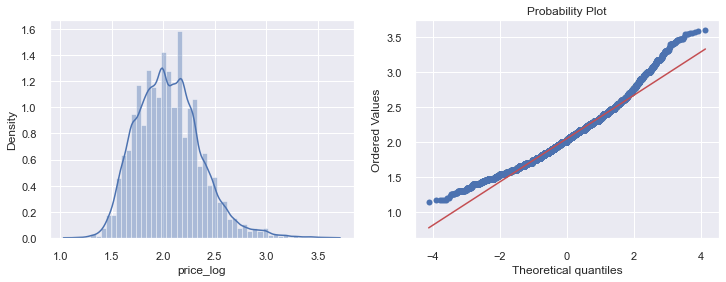

In [130]:
listings_cleaned = listings_df[(listings_df.price >= 14) & (listings_df.price < 5000)]
listings_cleaned['price_log'] = np.log10(listings_cleaned['price'])

fig, ax = plt.subplots(1,2, figsize=(12,4))

sns.distplot(listings_cleaned['price_log'], ax=ax[0])
stats.probplot(listings_cleaned['price_log'], dist="norm", plot=ax[1])

print("Skewness: %f" % listings_cleaned['price_log'].skew())
print("Kurtosis: %f" % listings_cleaned['price_log'].kurt())

In [131]:
listings_cleaned.shape

(36579, 16)

### Shape of final dataset
The final dataset that we will model with has 35,919 unqiue observations. with 42 columns that we will describe below. 

In [132]:
listings_cleaned.columns

Index(['id', 'latitude', 'longitude', 'accommodates', 'price',
       'availability_30', 'num_baths', 'neighbourhood_group_cleansed_Brooklyn',
       'neighbourhood_group_cleansed_Manhattan',
       'neighbourhood_group_cleansed_Queens',
       'neighbourhood_group_cleansed_Staten Island', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room', 'bath_type_shared',
       'price_log'],
      dtype='object')

<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

**Create functions to evaluate regression estimators** (MAE, MAPE, RMSE, and R-squared)

Credit: <a>https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb</a>


In [133]:
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, r2_score

def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

def mape(y_actual, y_predicted): 
    mask = y_actual != 0
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean() * 100

#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)
r2_scorer = make_scorer(score_func=r2_score, greater_is_better=True)

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'RMSE': rmse_scorer,
                'MAPE': mape_scorer,
                'R2': r2_scorer
               } 

### Methodology for dividing your Data : *Regression*

We will brief exceptions for to our methodology described that are unique to the regression task. 

> stratification was not used in the when seperating the data for validationa and cross-fold. Price is a continous variable. Unlike our classification task that looked at a binary True/False status of superhost. Price ranged from 14 - 5,000 dollars. Rather than impliment a someone arbituary cut off value, we left it alone. Randomization is used to extract validation and cross validation samples across the k folds. 
<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

In [134]:
#Split Modeling and Validation Datasets
from sklearn.model_selection import train_test_split

listings_modeling, listings_validation = train_test_split(listings_cleaned, test_size=0.1, random_state=42)

print("Size of modeling set (to be CV split): ",listings_modeling.shape)
print("Size of hold back validation set: ",listings_validation.shape)

Size of modeling set (to be CV split):  (32921, 16)
Size of hold back validation set:  (3658, 16)


In [135]:
#Create X and Y for modeling
X_price = listings_modeling.drop(['price','price_log','id'],axis=1) #droping rating_max
Y_price_log = listings_modeling['price_log']

#Create new X and Y for validation
X_price_valid = listings_validation.drop(['price','price_log','id'],axis=1) #droping rating_max
Y_price_log_valid = listings_validation['price_log']

In [136]:
#Standard scale the data
from sklearn.preprocessing import StandardScaler
std = StandardScaler()

std.fit(X_price.values) # only std.fit on train set
X_price_std = std.transform(X_price.values)
X_price_valid_std = std.transform(X_price_valid.values)

## **Cross Validation**
Cross validation is performed using repeated holdout via KFold()

- Ten folds are used
- The split is: 90% training data and 10% test data
- A random seed is set so the same random test and training splits are used each time cross validation is performed.

In [137]:
from sklearn.model_selection import KFold

cv_price = KFold(n_splits=10, shuffle=False)


> 
> ## Modeling and Evaluation 3:
> Create three different *Classification* models (e.g., random forest, KNN, and Logistic Regression).
> 

Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization

> #### [20 points]

Eight regression models were conducted using GridSearchCV to find the best regression model that fit the modeling dataset.
1) Linear Regression
2) Ridge Regression
3) Lasso Regression
4) Elastic Net Regression
5) Support Vector Regression
6) Random Forest Regressor
7) Extra Trees Regressor
8) K Neighbors Regressor



We created 2 functions for regression model and residual plots as below.

In [138]:
#Create function for regression models
from sklearn.model_selection import cross_validate

def EvaluateRegressionEstimator(modelNme, regEstimator, X, y, x_valid, y_valid, cv):
    
    print('Parameterization of the best estimator:',regEstimator,'\n')

    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    yhat = regEstimator.predict(x_valid)

    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

    #print mean test_MAPE for all folds
    mape_avg = scores['test_MAPE'].mean()
    print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
    print(print_str.format(mape_avg=mape_avg))

    #print mean RMSE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))

    #print R2 for all folds 
    R2avg = scores['test_R2'].mean()
    print_str = "The average R2 for all cv folds is: \t\t\t {R2avg:.5}"
    print(print_str.format(R2avg=R2avg))
    print('---------------------------------------------------------------------')

    model_stat = pd.DataFrame()
    model_stat['Model_name'] = [str(modelNme)]
    model_stat['MAE_model'] = scores['test_MAE'].mean()
    model_stat['MAPE_model'] = scores['test_MAPE'].mean()
    model_stat['RMSE_model'] = scores['test_RMSE'].mean()
    model_stat['R2_model'] = scores['test_R2'].mean()
    model_stat['MAE_validation'] = mean_absolute_error(y_valid, yhat)
    model_stat['MAPE_validation'] = mape(y_valid, yhat)
    model_stat['RMSE_validation'] = rmse(y_valid, yhat)
    model_stat['R2_validation'] = r2_score(y_valid, yhat)

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    scoresResults['R2'] = scores['test_R2']
    print(scoresResults)
    
    return model_stat, model_stat['MAE_validation']

In [139]:
#Create Function for Prediction Error, Residual and Cook's D Plots
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import CooksDistance

def residualPlot(model, x_train, y_train, x_test, y_test):
    print('\n*********************************************\nPrediction Error, Residual and Cook\'s D Plots\n*********************************************')

    predictions = model.predict(x_train)
    residuals = y_train - predictions
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(residuals))

    plt.subplots(1, 2, figsize=(14, 4))
    plt.subplot(121)
    visualizer = PredictionError(model)
    visualizer.fit(x_train, y_train)
    visualizer.score(x_test, y_test)
    visualizer.finalize()

    plt.subplot(122)
    visualizer = ResidualsPlot(model, hist=False, qqplot=True)
    visualizer.fit(x_train, y_train)
    visualizer.score(x_test, y_test)
    visualizer.show()
    plt.show()

    plt.subplots(1, 2, figsize=(13,4))    
    plt.subplot(121)
    sns.regplot(predictions, model_norm_residuals_abs_sqrt,
                scatter=True,
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    plt.ylabel("Standarized residuals")
    plt.xlabel("Fitted value")

    y = np.array(y_train, dtype=float)
    x = np.array(x_train, dtype=float)
    plt.subplot(122)
    visualizer = CooksDistance()
    visualizer.fit(x, y)
    visualizer.show()

In [140]:
#Create dataframe to collect regression models stat
regModel_stat = pd.DataFrame()

<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

<a id="RF"></a>
___
# Data Understanding: Random Forest
Running Random forest model. Later we ill include outputs from our clustering analysis in attempt to improve model performance.
___

In [141]:
#Base model is RandomForestRegressor(min_samples_leaf=10, min_samples_split=5, n_estimators=500)

from sklearn.ensemble import RandomForestRegressor

rfRandomEstimator = RandomForestRegressor(min_samples_leaf=10, min_samples_split=5, n_estimators=500, n_jobs=8, random_state=0)
rfRandomEstimator.fit(X_price_std, Y_price_log)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
rf, rfMae = EvaluateRegressionEstimator('Random Forest Regressor', rfRandomEstimator, X_price_std, Y_price_log, X_price_valid_std, Y_price_log_valid, cv_price)
regModel_stat = regModel_stat.append(rf)

Parameterization of the best estimator: RandomForestRegressor(min_samples_leaf=10, min_samples_split=5,
                      n_estimators=500, n_jobs=8, random_state=0) 

The average MAE for all cv folds is: 			 0.13127
The average MAE percentage (MAPE) for all cv folds is: 	 6.3772
The average RMSE for all cv folds is: 			 0.18159
The average R2 for all cv folds is: 			 0.66471
---------------------------------------------------------------------
Cross Validation Fold Mean Error Scores
        MAE      MAPE      RMSE        R2
0  0.132317  6.462232  0.183365  0.642062
1  0.128631  6.241250  0.174927  0.685431
2  0.130921  6.338835  0.184824  0.664396
3  0.133186  6.485113  0.183796  0.649419
4  0.130472  6.359707  0.178534  0.689187
5  0.129460  6.305482  0.178350  0.665725
6  0.135215  6.497637  0.192900  0.638289
7  0.129271  6.299239  0.176694  0.681378
8  0.133103  6.432136  0.184965  0.653259
9  0.130116  6.349894  0.177573  0.677930


In [142]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
randomForrestReg_weights = rfRandomEstimator.feature_importances_.ravel()
randomForrestReg_feature_names = X_price_valid.columns.values
randomForrestReg_ft_imp_df = pd.DataFrame({'feature_names':randomForrestReg_feature_names, 'weights':randomForrestReg_weights, 'absolute_weights': np.abs(randomForrestReg_weights)})
randomForrestReg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False)

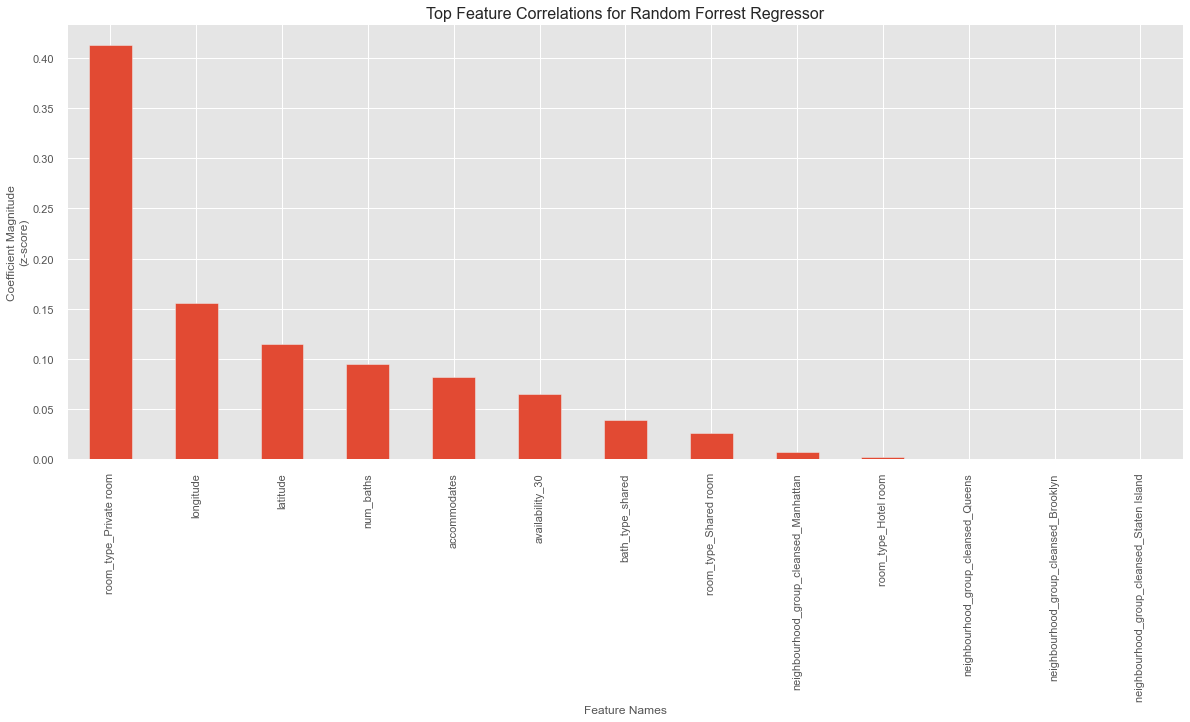

In [143]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

randomForrestReg_wt_plt_df = randomForrestReg_ft_imp_df.head(75)

randomForrestReg_weights = pd.Series(randomForrestReg_wt_plt_df['weights'].values,index=randomForrestReg_wt_plt_df['feature_names'])
ax = randomForrestReg_weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Top Feature Correlations for Random Forrest Regressor", fontsize=16)
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

Longitude and Lattitude are the 2nd and 3rd most important features. Now we will begin working with 3 different clustering algorithms. We will if there are interesting clustering within the data. Then use these clustering algorithms to try and improve regression performance.

<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

In [144]:
listings_modeling.head()

,id,latitude,longitude,accommodates,price,availability_30,num_baths,neighbourhood_group_cleansed_Brooklyn,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,neighbourhood_group_cleansed_Staten Island,room_type_Hotel room,room_type_Private room,room_type_Shared room,bath_type_shared,price_log
19277,29828333,40.82263,-73.94332,6,230.0,30,2.0,0,1,0,0,0,0,0,0,2.361728
5702,7397649,40.76297,-73.92696,3,132.0,0,1.0,0,0,1,0,0,0,0,0,2.120574
33666,49289061,40.75772,-73.99546,3,299.0,30,1.0,0,1,0,0,0,0,0,0,2.475671
29146,45115299,40.72779,-74.00050,2,126.0,0,1.0,0,1,0,0,0,0,0,0,2.100371
30590,46428638,40.70518,-74.00587,4,163.0,23,1.0,0,1,0,0,0,1,0,0,2.212188


In [145]:
Lat = listings_modeling.latitude
Long = listings_modeling.longitude

LatLong = np.column_stack((Lat, Long))

LatLong.shape


(32921, 2)

___
# Modeling and Evaluation 1: DBSCAN

Train and adjust parameters
___
<a id="me1d"></a> 

Use Kneighbors to explore values for min-points and eps hyperparameters

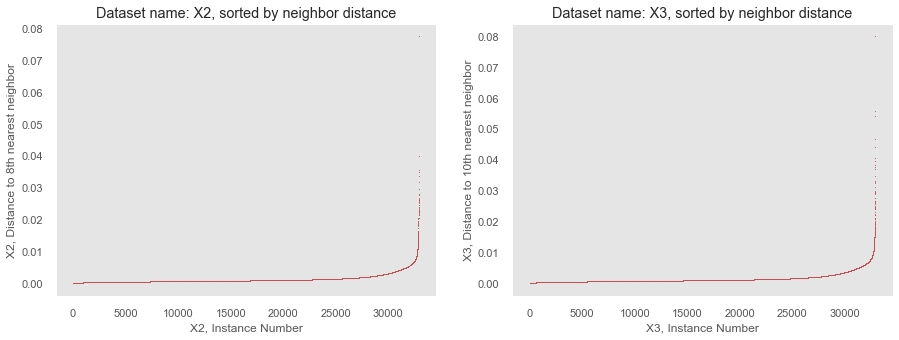

In [146]:
# lets first look at the connectivity of the graphs and distance to the nearest neighbors
from sklearn.neighbors import kneighbors_graph

#=======================================================
# CHANGE THESE VALUES TO ADJUST MINPTS FOR EACH DATASET
X2_N = 8
X3_N = 10
#=======================================================

# create connectivity graphs before calcualting the hierarchy
X2_knn_graph = kneighbors_graph(LatLong, X2_N, mode='distance') # calculate distance to four nearest neighbors 
X3_knn_graph = kneighbors_graph(LatLong, X3_N, mode='distance') # calculate distance to four nearest neighbors 

N2 = X2_knn_graph.shape[0]
X2_4nn_distances = np.zeros((N2,1))
for i in range(N2):
    X2_4nn_distances[i] = X2_knn_graph[i,:].max()

X2_4nn_distances = np.sort(X2_4nn_distances, axis=0)

N3 = X3_knn_graph.shape[0]
X3_4nn_distances = np.zeros((N3,1))
for i in range(N2):
    X3_4nn_distances[i] = X3_knn_graph[i,:].max()

X3_4nn_distances = np.sort(X3_4nn_distances, axis=0)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(N2), X2_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('Dataset name: X2, sorted by neighbor distance')
plt.xlabel('X2, Instance Number')
plt.ylabel('X2, Distance to {0}th nearest neighbor'.format(X2_N))
plt.grid()

plt.subplot(1,2,2)
plt.plot(range(N3), X3_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('Dataset name: X3, sorted by neighbor distance')
plt.xlabel('X3, Instance Number')
plt.ylabel('X3, Distance to {0}th nearest neighbor'.format(X3_N))
plt.grid()

plt.show()

Build base model for DBSCAN and plot cluster mapping

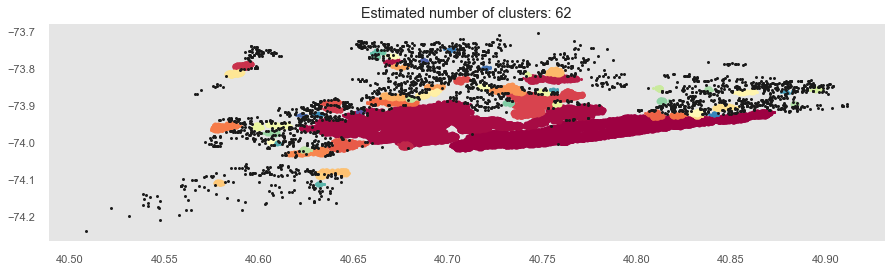

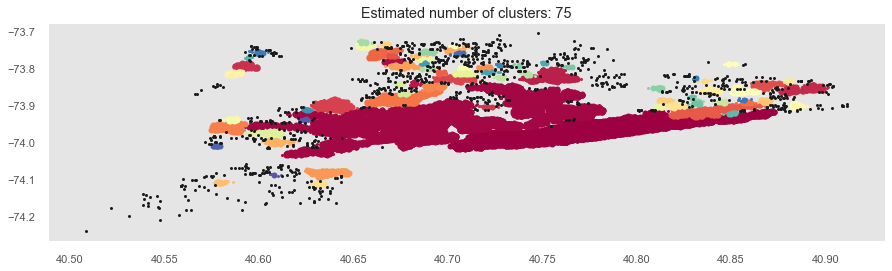

In [147]:
from sklearn.cluster import DBSCAN

#=====================================
# ENTER YOUR CODE HERE TO CHANGE MINPTS AND EPS FOR EACH DATASET
X2_minpts = 10 # from above
X2_eps = 0.003
X3_minpts = 8 # from above
X3_eps = 0.004
#=====================================

for i, (data, minpts, eps) in enumerate(zip([LatLong,LatLong],[X2_minpts,X3_minpts],[X2_eps,X3_eps])):

    db = DBSCAN(eps=eps, min_samples=minpts).fit(data)
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    # mark the samples that are considered "core"
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    plt.figure(figsize=(15,4))
    unique_labels = set(labels) # the unique labels
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = 'k'

        class_member_mask = (labels == k)

        xy = data[class_member_mask & core_samples_mask]
        # plot the core points in this class
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='w', markersize=6)

        # plot the remaining points that are edge points
        xy = data[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='w', markersize=3)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.grid()
    plt.show()

___
# Modeling and Evaluation 2: DBSCAN

Evaluate and Compare
___

<a id="me1d"></a> 

See example code in kmeans section below. Kmeans has one loop to explore range of n_clusters. DBSCAN will need a nested loop to look at grid ranges for both min_samples and eps

___
# Modeling and Evaluation 3: DBSCAN

Visualize Results
___
<a id="me3d"></a> 

___
# Modeling and Evaluation 4: DBSCAN

Summarize the Rammifications
___
<a id="me4d"></a> 


<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

___
# Modeling and Evaluation 1: KMeans

Train and adjust parameters
___
<a id="me1k"></a> 

Build base model with fixed clusters and plot centroids

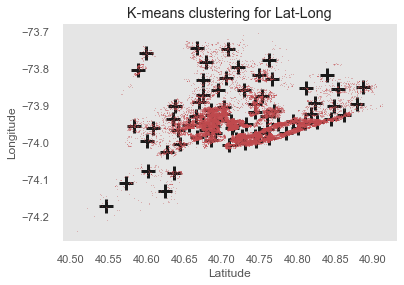

In [149]:
from sklearn.cluster import KMeans

#--------Change parameters below this line---------------------------
# CHANGE THE PARAMETERS HERE TO GET A CONSISTENTLY OPTIMAL CLUSTERING
# run kmeans algorithm (this is the most traditional use of k-means)
kmeans = KMeans(
    init='k-means++',    # initialization
    n_clusters=75,    # number of clusters
    n_init=1,         # number of different times to run k-means
    n_jobs=-1)
#--------Change parameters above this line---------------------------

kmeans.fit(LatLong)

# visualize the data
centroids = kmeans.cluster_centers_
plt.plot(LatLong[:, 0], LatLong[:, 1], 'r.', markersize=1) #plot the data
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, color='k')  # plot the centroids
plt.title('K-means clustering for Lat-Long')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.grid()
plt.show()

Make predictions on labels and plot map of clusters

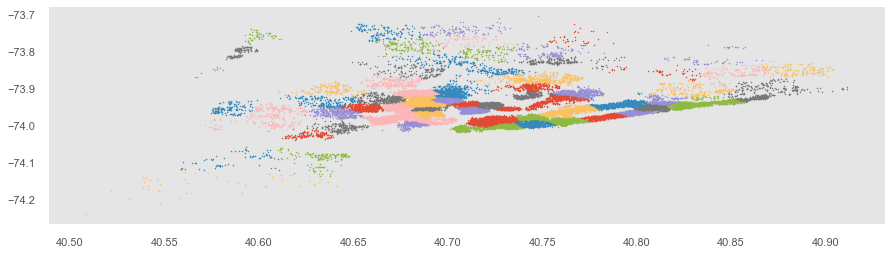

In [150]:
label = kmeans.fit_predict(LatLong)

#Getting unique labels
 
u_labels = np.unique(label)
 
#plotting the results:

plt.figure(figsize=(15,4)) 
for i in u_labels:
    plt.scatter(LatLong[label == i , 0] , LatLong[label == i , 1] , label = i, s=1)
plt.grid()
plt.show()

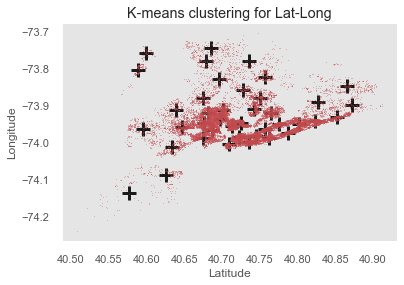

In [151]:
from sklearn.cluster import KMeans

#--------Change parameters below this line---------------------------
# CHANGE THE PARAMETERS HERE TO GET A CONSISTENTLY OPTIMAL CLUSTERING
# run kmeans algorithm (this is the most traditional use of k-means)
kmeans = KMeans(
    init='k-means++',    # initialization
    n_clusters=40,    # number of clusters
    n_init=1,         # number of different times to run k-means
    n_jobs=-1)
#--------Change parameters above this line---------------------------

kmeans.fit(LatLong)

# visualize the data
centroids = kmeans.cluster_centers_
plt.plot(LatLong[:, 0], LatLong[:, 1], 'r.', markersize=1) #plot the data
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, color='k')  # plot the centroids
plt.title('K-means clustering for Lat-Long')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.grid()
plt.show()

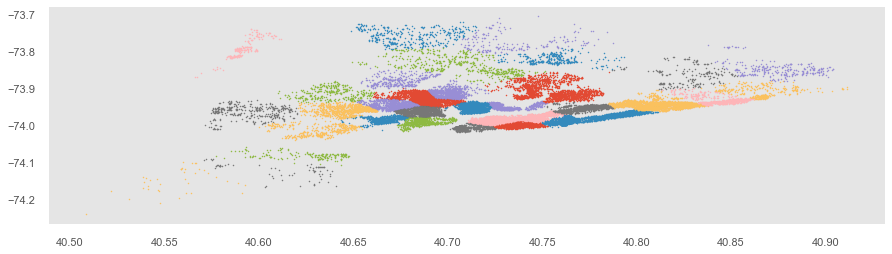

In [152]:
label = kmeans.fit_predict(LatLong)

#Getting unique labels
 
u_labels = np.unique(label)
 
#plotting the results:

plt.figure(figsize=(15,4)) 
for i in u_labels:
    plt.scatter(LatLong[label == i , 0] , LatLong[label == i , 1] , label = i, s=1)
plt.grid()
plt.show()

___
# Modeling and Evaluation 2: KMeans

Train and adjust parameters
___
<a id="me2k"></a> 

Tune hyperparameters by looping through range of n_clusters

Plot SSE and Silhouette metrics to find optimal number of clusters

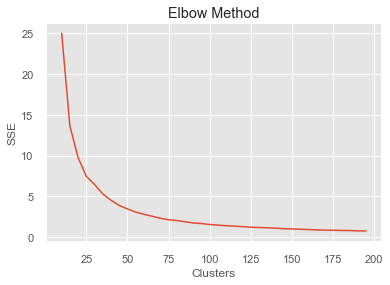

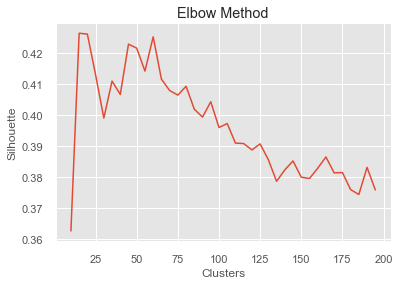

In [155]:
from sklearn.metrics import silhouette_score

kmeans_silhouette = []
kmeans_SSE = []

for i in range(10,200,5):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', n_init = 1, n_jobs=-1)
    kmeans.fit(LatLong)
    kmeans_SSE.append(kmeans.inertia_) #Collects all of the within cluster sum of squares
    kmeans_silhouette.append(silhouette_score(LatLong, kmeans.labels_, metric='euclidean'))

plt.plot(range(10,200,5), kmeans_SSE)
plt.title('Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.show()

plt.plot(range(10,200,5), kmeans_silhouette)
plt.title('Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('Silhouette')
plt.show()

___
# Modeling and Evaluation 3: KMeans

Evaluate and Compare
___
<a id="me3k"></a> 

 **Based on plots above, setting number of clusters to 60 would be below the elbow on SSE metric and still in the higher silihouette range which drops off as you increase number of clusters**

## Run Tuned clustering model for both the modeling and validation data sets and plot cluster maps

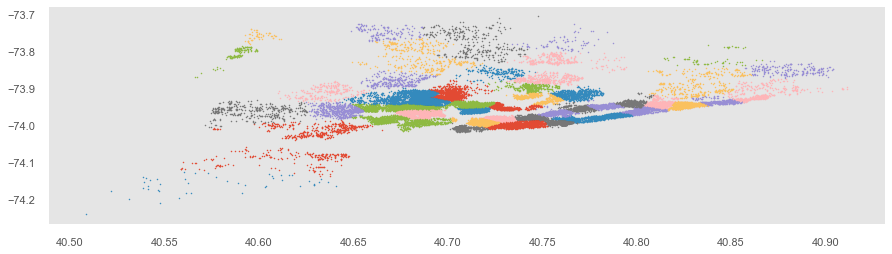

In [156]:
#--------Change parameters below this line---------------------------
# CHANGE THE PARAMETERS HERE TO GET A CONSISTENTLY OPTIMAL CLUSTERING
# run kmeans algorithm (this is the most traditional use of k-means)
kmeans_tuned = KMeans(
    init='k-means++',    # initialization
    n_clusters=60,    # number of clusters
    n_init=1,         # number of different times to run k-means
    n_jobs=-1)
#--------Change parameters above this line---------------------------

model_train = kmeans_tuned.fit(LatLong)

label = model_train.predict(LatLong)

#Getting unique labels
 
u_labels = np.unique(label)
 
#plotting the results:

plt.figure(figsize=(15,4)) 
for i in u_labels:
    plt.scatter(LatLong[label == i , 0] , LatLong[label == i , 1] , label = i, s=1)
plt.grid()
plt.show()

___
# Modeling and Evaluation 4: KMeans

Summarize the Ramifications
___
<a id="me4k"></a> 


<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

In [157]:
Lat_val = listings_validation.latitude
Long_val = listings_validation.longitude

LatLong_val = np.column_stack((Lat_val, Long_val))

LatLong_val.shape

(3658, 2)

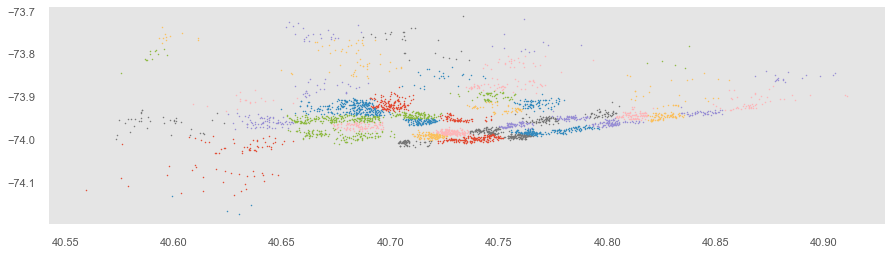

In [158]:
label_val = model_train.predict(LatLong_val)

#Getting unique labels
 
u_labels = np.unique(label_val)
 
#plotting the results:

plt.figure(figsize=(15,4)) 
for i in u_labels:
    plt.scatter(LatLong_val[label_val == i , 0] , LatLong_val[label_val == i , 1] , label = i, s=1)
plt.grid()
plt.show()

In [75]:
listings_modeling.head()

,id,latitude,longitude,accommodates,price,availability_30,num_baths,neighbourhood_group_cleansed_Brooklyn,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,neighbourhood_group_cleansed_Staten Island,room_type_Hotel room,room_type_Private room,room_type_Shared room,bath_type_shared,price_log
19277,29828333,40.82263,-73.94332,6,230.0,30,2.0,0,1,0,0,0,0,0,0,2.361728
5702,7397649,40.76297,-73.92696,3,132.0,0,1.0,0,0,1,0,0,0,0,0,2.120574
33666,49289061,40.75772,-73.99546,3,299.0,30,1.0,0,1,0,0,0,0,0,0,2.475671
29146,45115299,40.72779,-74.00050,2,126.0,0,1.0,0,1,0,0,0,0,0,0,2.100371
30590,46428638,40.70518,-74.00587,4,163.0,23,1.0,0,1,0,0,0,1,0,0,2.212188


In [98]:
listings_modeling['cluster'] = label
listings_modeling.head()

,id,latitude,longitude,accommodates,price,availability_30,num_baths,neighbourhood_group_cleansed_Brooklyn,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,neighbourhood_group_cleansed_Staten Island,room_type_Hotel room,room_type_Private room,room_type_Shared room,bath_type_shared,price_log,cluster
19277,29828333,40.82263,-73.94332,6,230.0,30,2.0,0,1,0,0,0,0,0,0,2.361728,4
5702,7397649,40.76297,-73.92696,3,132.0,0,1.0,0,0,1,0,0,0,0,0,2.120574,19
33666,49289061,40.75772,-73.99546,3,299.0,30,1.0,0,1,0,0,0,0,0,0,2.475671,28
29146,45115299,40.72779,-74.00050,2,126.0,0,1.0,0,1,0,0,0,0,0,0,2.100371,8
30590,46428638,40.70518,-74.00587,4,163.0,23,1.0,0,1,0,0,0,1,0,0,2.212188,36


In [99]:
listings_validation['cluster'] = label_val
listings_validation.head()

,id,latitude,longitude,accommodates,price,availability_30,num_baths,neighbourhood_group_cleansed_Brooklyn,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,neighbourhood_group_cleansed_Staten Island,room_type_Hotel room,room_type_Private room,room_type_Shared room,bath_type_shared,price_log,cluster
19615,30308289,40.80098,-73.96911,2,199.0,1,1.0,0,1,0,0,0,0,0,0,2.298853,17
17033,25057198,40.79178,-73.97397,5,250.0,0,1.0,0,1,0,0,0,0,0,0,2.397940,17
6880,9058854,40.67046,-73.95298,1,25.0,0,1.0,1,0,0,0,0,1,0,0,1.397940,14
24229,38667434,40.76601,-73.79413,8,234.0,0,2.0,0,0,1,0,0,1,0,0,2.369216,24
30476,46336040,40.74972,-73.98467,4,115.0,0,1.0,0,1,0,0,0,1,0,0,2.060698,12


In [100]:
#Create X and Y for modeling
X_price = listings_modeling.drop(['id','price','price_log','latitude','longitude'],axis=1) #droping rating_max
Y_price_log = listings_modeling['price_log']

#Create new X and Y for validation
X_price_valid = listings_validation.drop(['id','price','price_log','latitude','longitude'],axis=1) #droping rating_max
Y_price_log_valid = listings_validation['price_log']

#Standard scale the data
from sklearn.preprocessing import StandardScaler
std = StandardScaler()

std.fit(X_price.values) # only std.fit on train set
X_price_std = std.transform(X_price.values)
X_price_valid_std = std.transform(X_price_valid.values)

In [101]:
#Best model is RandomForestRegressor(min_samples_leaf=10, min_samples_split=5, n_estimators=500)

from sklearn.ensemble import RandomForestRegressor

rfRandomEstimator = RandomForestRegressor(min_samples_leaf=10, min_samples_split=5, n_estimators=500, n_jobs=8, random_state=0)
rfRandomEstimator.fit(X_price_std, Y_price_log)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
rf, rfMae = EvaluateRegressionEstimator('Random Forest Regressor', rfRandomEstimator, X_price_std, Y_price_log, X_price_valid_std, Y_price_log_valid, cv_price)
regModel_stat = regModel_stat.append(rf)

Parameterization of the best estimator: RandomForestRegressor(min_samples_leaf=10, min_samples_split=5,
                      n_estimators=500, n_jobs=8, random_state=0) 

The average MAE for all cv folds is: 			 0.13728
The average MAE percentage (MAPE) for all cv folds is: 	 6.6705
The average RMSE for all cv folds is: 			 0.18809
The average R2 for all cv folds is: 			 0.64033
---------------------------------------------------------------------
Cross Validation Fold Mean Error Scores
        MAE      MAPE      RMSE        R2
0  0.137526  6.716657  0.189135  0.619181
1  0.135475  6.590471  0.182128  0.658998
2  0.138163  6.677115  0.192397  0.636330
3  0.138814  6.765658  0.189842  0.625976
4  0.135953  6.634725  0.184276  0.668874
5  0.133613  6.501160  0.182836  0.648698
6  0.141212  6.792771  0.199482  0.613185
7  0.135357  6.591035  0.183409  0.656700
8  0.139323  6.730461  0.192474  0.624534
9  0.137342  6.705163  0.184898  0.650810


In [102]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
randomForrestReg_weights = rfRandomEstimator.feature_importances_.ravel()
randomForrestReg_feature_names = X_price_valid.columns.values
randomForrestReg_ft_imp_df = pd.DataFrame({'feature_names':randomForrestReg_feature_names, 'weights':randomForrestReg_weights, 'absolute_weights': np.abs(randomForrestReg_weights)})
randomForrestReg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False)

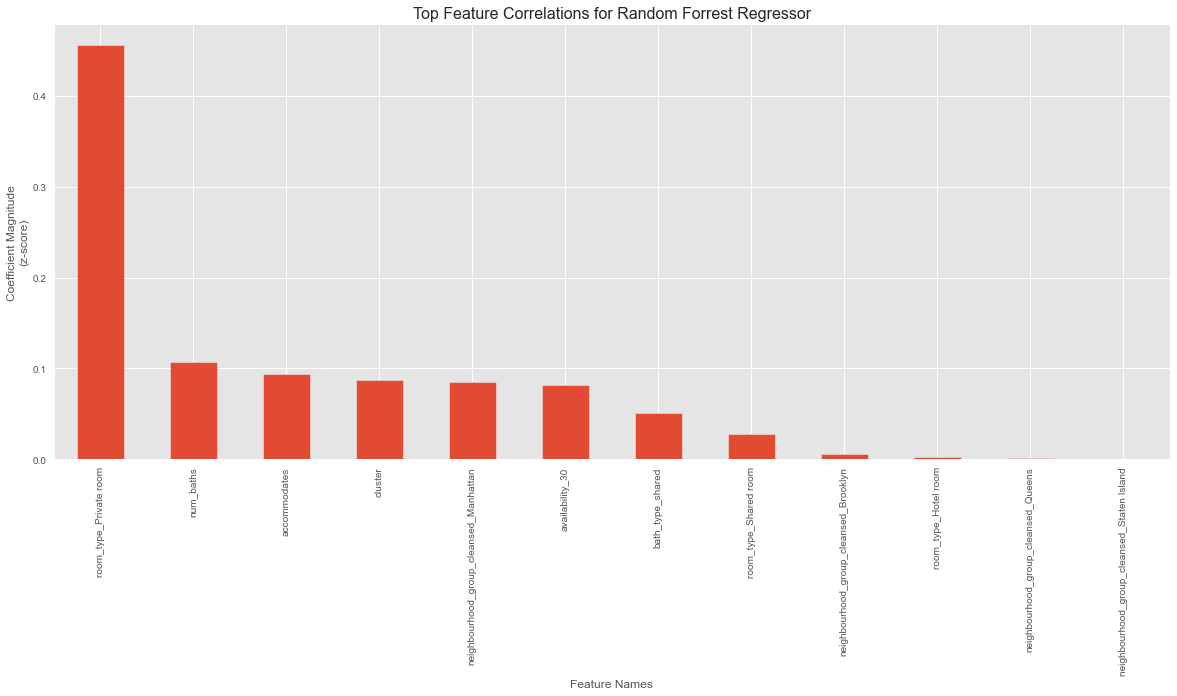

In [103]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

randomForrestReg_wt_plt_df = randomForrestReg_ft_imp_df.head(75)

randomForrestReg_weights = pd.Series(randomForrestReg_wt_plt_df['weights'].values,index=randomForrestReg_wt_plt_df['feature_names'])
ax = randomForrestReg_weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Top Feature Correlations for Random Forrest Regressor", fontsize=16)
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

One-hot encode clustering

In [88]:
listings_modeling.cluster = pd.Categorical(listings_modeling.cluster)

Categoricals_to_convert = ['cluster']

# using pd get dummies for the category columns we are keeping
dummies = pd.get_dummies(listings_modeling[Categoricals_to_convert],drop_first=True)

#dropping original columns
listings_cluster1 = listings_modeling.drop(Categoricals_to_convert,axis=1)

#concating dummies to the data frame
listings_cluster1 = pd.concat([listings_cluster1,dummies],axis=1)

listings_cluster1.head()

,id,latitude,longitude,accommodates,price,availability_30,num_baths,neighbourhood_group_cleansed_Brooklyn,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,neighbourhood_group_cleansed_Staten Island,room_type_Hotel room,room_type_Private room,room_type_Shared room,bath_type_shared,price_log,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19,cluster_20,cluster_21,cluster_22,cluster_23,cluster_24,cluster_25,cluster_26,cluster_27,cluster_28,cluster_29,cluster_30,cluster_31,cluster_32,cluster_33,cluster_34,cluster_35,cluster_36,cluster_37,cluster_38,cluster_39
19277,29828333,40.82263,-73.94332,6,230.0,30,2.0,0,1,0,0,0,0,0,0,2.361728,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5702,7397649,40.76297,-73.92696,3,132.0,0,1.0,0,0,1,0,0,0,0,0,2.120574,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
33666,49289061,40.75772,-73.99546,3,299.0,30,1.0,0,1,0,0,0,0,0,0,2.475671,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
29146,45115299,40.72779,-74.00050,2,126.0,0,1.0,0,1,0,0,0,0,0,0,2.100371,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30590,46428638,40.70518,-74.00587,4,163.0,23,1.0,0,1,0,0,0,1,0,0,2.212188,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [89]:
listings_validation.cluster = pd.Categorical(listings_validation.cluster)

Categoricals_to_convert = ['cluster']

# using pd get dummies for the category columns we are keeping
dummies = pd.get_dummies(listings_validation[Categoricals_to_convert],drop_first=True)

#dropping original columns
validation_cluster1 = listings_validation.drop(Categoricals_to_convert,axis=1)

#concating dummies to the data frame
validation_cluster1 = pd.concat([validation_cluster1,dummies],axis=1)

validation_cluster1.head()

,id,latitude,longitude,accommodates,price,availability_30,num_baths,neighbourhood_group_cleansed_Brooklyn,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,neighbourhood_group_cleansed_Staten Island,room_type_Hotel room,room_type_Private room,room_type_Shared room,bath_type_shared,price_log,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19,cluster_20,cluster_21,cluster_22,cluster_23,cluster_24,cluster_25,cluster_26,cluster_27,cluster_28,cluster_29,cluster_30,cluster_31,cluster_32,cluster_33,cluster_34,cluster_35,cluster_36,cluster_37,cluster_38,cluster_39
19615,30308289,40.80098,-73.96911,2,199.0,1,1.0,0,1,0,0,0,0,0,0,2.298853,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17033,25057198,40.79178,-73.97397,5,250.0,0,1.0,0,1,0,0,0,0,0,0,2.397940,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6880,9058854,40.67046,-73.95298,1,25.0,0,1.0,1,0,0,0,0,1,0,0,1.397940,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24229,38667434,40.76601,-73.79413,8,234.0,0,2.0,0,0,1,0,0,1,0,0,2.369216,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30476,46336040,40.74972,-73.98467,4,115.0,0,1.0,0,1,0,0,0,1,0,0,2.060698,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [94]:
#Create X and Y for modeling
X_price = listings_cluster1.drop(['id','price','price_log','latitude','longitude'],axis=1) #droping rating_max
Y_price_log = listings_cluster1['price_log']

#Create new X and Y for validation
X_price_valid = validation_cluster1.drop(['id','price','price_log','latitude','longitude'],axis=1) #droping rating_max
Y_price_log_valid = validation_cluster1['price_log']

#Standard scale the data
from sklearn.preprocessing import StandardScaler
std = StandardScaler()

std.fit(X_price.values) # only std.fit on train set
X_price_std = std.transform(X_price.values)
X_price_valid_std = std.transform(X_price_valid.values)

In [95]:
#Best model is RandomForestRegressor(min_samples_leaf=10, min_samples_split=5, n_estimators=500)

from sklearn.ensemble import RandomForestRegressor

rfRandomEstimator = RandomForestRegressor(min_samples_leaf=10, min_samples_split=5, n_estimators=500, n_jobs=8, random_state=0)
rfRandomEstimator.fit(X_price_std, Y_price_log)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
rf, rfMae = EvaluateRegressionEstimator('Random Forest Regressor', rfRandomEstimator, X_price_std, Y_price_log, X_price_valid_std, Y_price_log_valid, cv_price)
regModel_stat = regModel_stat.append(rf)

Parameterization of the best estimator: RandomForestRegressor(min_samples_leaf=10, min_samples_split=5,
                      n_estimators=500, n_jobs=8, random_state=0) 

The average MAE for all cv folds is: 			 0.13682
The average MAE percentage (MAPE) for all cv folds is: 	 6.6474
The average RMSE for all cv folds is: 			 0.18726
The average R2 for all cv folds is: 			 0.64347
---------------------------------------------------------------------
Cross Validation Fold Mean Error Scores
        MAE      MAPE      RMSE        R2
0  0.137583  6.722471  0.188669  0.621057
1  0.134756  6.548941  0.181157  0.662624
2  0.137199  6.628107  0.191048  0.641415
3  0.138710  6.759362  0.188999  0.629291
4  0.135303  6.597638  0.183707  0.670917
5  0.132806  6.463795  0.182262  0.650900
6  0.141521  6.814052  0.199284  0.613953
7  0.135082  6.578341  0.182404  0.660451
8  0.139039  6.711805  0.191705  0.627528
9  0.136171  6.649786  0.183357  0.656606


**Base model results without clustering were:**
The average MAE for all cv folds is: 			 0.13133
The average MAE percentage (MAPE) for all cv folds is: 	 6.38
The average RMSE for all cv folds is: 			 0.18161
The average R2 for all cv folds is: 			 0.66462

In [96]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
randomForrestReg_weights = rfRandomEstimator.feature_importances_.ravel()
randomForrestReg_feature_names = X_price_valid.columns.values
randomForrestReg_ft_imp_df = pd.DataFrame({'feature_names':randomForrestReg_feature_names, 'weights':randomForrestReg_weights, 'absolute_weights': np.abs(randomForrestReg_weights)})
randomForrestReg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False)

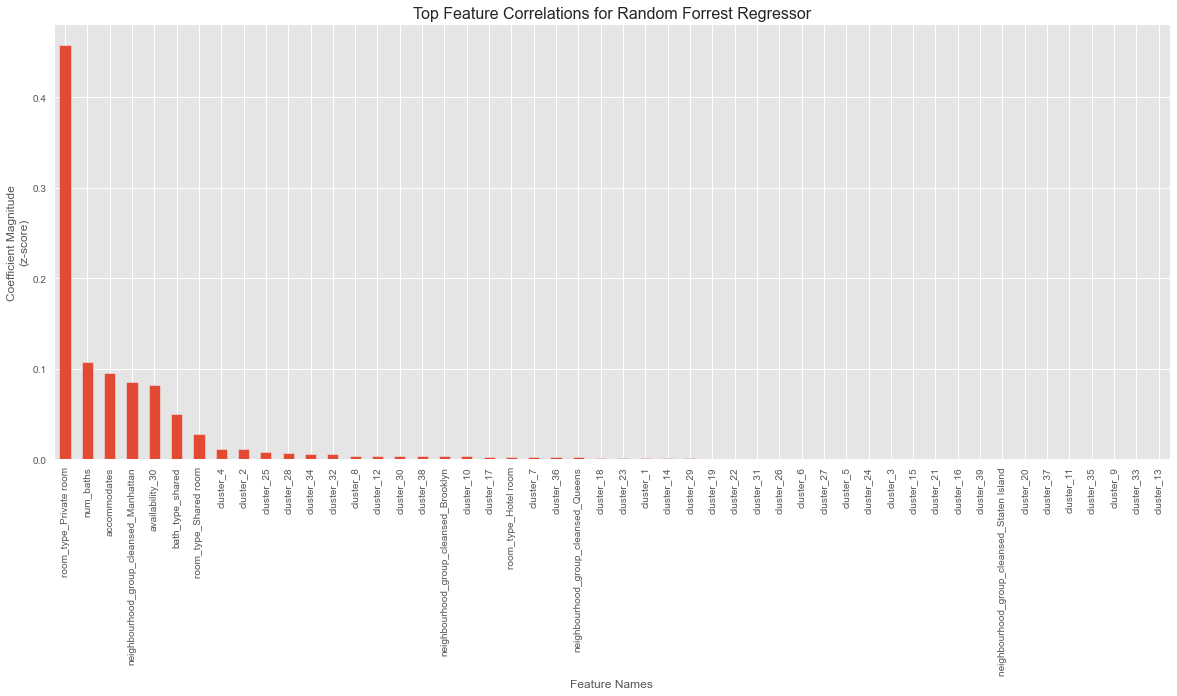

In [97]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

randomForrestReg_wt_plt_df = randomForrestReg_ft_imp_df.head(75)

randomForrestReg_weights = pd.Series(randomForrestReg_wt_plt_df['weights'].values,index=randomForrestReg_wt_plt_df['feature_names'])
ax = randomForrestReg_weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Top Feature Correlations for Random Forrest Regressor", fontsize=16)
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

___
# Modeling and Evaluation 1: Spectral Clustering

Train and adjust parameters
___
<a id="me1s"></a> 

Build Base models

In [159]:
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph

#object to cluster on
# LatLong = np.column_stack((Lat, Long))

#nclust = n_clusters default is 8 

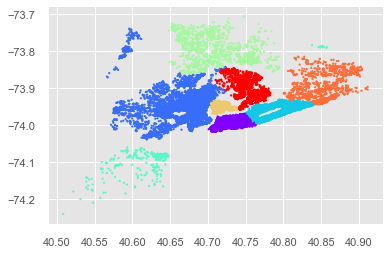

In [160]:
#default model

X= LatLong

#running with default n_clusters, assign_labels = 'kmeans' default
spc = SpectralClustering(affinity = 'nearest_neighbors')
labels = spc.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels,
                    cmap=plt.cm.rainbow, s=5, linewidths=0)

plt.show()

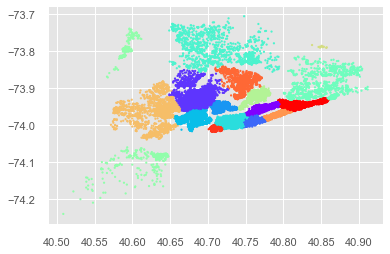

In [161]:
#adjusting n_clusters
nclust = 16
X= LatLong

#running with default n_clusters, assign_labels = 'kmeans' default
spc = SpectralClustering(n_clusters=nclust ,affinity = 'nearest_neighbors')
labels = spc.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels,
                    cmap=plt.cm.rainbow, s=5, linewidths=0)

plt.show()

#hard to say if this is better

In [162]:
# using professors code to calculate our own affinity metrix. 
#using default n_clusters

from sklearn.metrics.pairwise import pairwise_distances

X= LatLong

d = pairwise_distances(X, metric='euclidean')
d = np.exp(- d**2 / (2.* 0.1**2)) # convert from euclidean distance to similarity
# this is Eric's function, empirically it works

spc = SpectralClustering(affinity = 'precomputed', eigen_solver = 'arpack')
labels = spc.fit_predict(d) 

plt.scatter(X[:, 0], X[:, 1], c=labels,
                    cmap=plt.cm.rainbow, s=5, linewidths=0)

plt.show()

___
# Modeling and Evaluation 2: Spectral Clustering

Evaluate and Compare
___
<a id="me2s"></a> 

In [ ]:
#Insert Code for tuning see example code above in kmeans section

___
# Modeling and Evaluation 3: Spectral Clustering

Visualize Results
___
<a id="me3s"></a> 

___
# Modeling and Evaluation 4: Spectral Clustering

Summarize the Ramifications 
___
<a id="me4s"></a> 

<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

___
# Deployment

Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling? How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?
___
<a id="deploy"></a> 


<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

___
# Exceptional Work

Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling? How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?
___
<a id="ex"></a> 

<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

___
# References
___


<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>